In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import importlib
import os
import pickle

import agps_optim
importlib.reload(agps_optim)
from agps_optim import get_df_movements, calculate_normal_taxi_fuel, calculate_agps_taxi_fuel, run_optimization_for_multiDays_MILP

from agps_config import DISTANCE_MATRIX, DEFAULT_BUFFER_AGPS, DEFAULT_SFC_AGPS, DEFAULT_STARTUP_TIME, DEFAULT_WARMUP_TIME, DEFAULT_SPEED_AGPS

In [24]:
# Some layout settings for the plots
fontsize_ticks = 14
fontsize_xylabels = 16
fontsize_title = 16

In [2]:
param_ranges = {
    'startupTime':  {'low': DEFAULT_STARTUP_TIME*0.8,'baseline': DEFAULT_STARTUP_TIME,'high': DEFAULT_STARTUP_TIME*1.2},            # seconds
    'warmupTime':   {'low': DEFAULT_WARMUP_TIME*0.8, 'baseline': DEFAULT_WARMUP_TIME, 'high': DEFAULT_WARMUP_TIME*1.2},           # seconds
    'agps_sfc':     {'low': DEFAULT_SFC_AGPS*0.8,    'baseline': DEFAULT_SFC_AGPS,    'high': DEFAULT_SFC_AGPS*1.2},     # kg/hr
    'agps_speed':   {'low': DEFAULT_SPEED_AGPS*0.8,  'baseline': DEFAULT_SPEED_AGPS,  'high': DEFAULT_SPEED_AGPS*1.2},            # km/h
    'buffer_time':  {'low': DEFAULT_BUFFER_AGPS*0.8, 'baseline': DEFAULT_BUFFER_AGPS, 'high': DEFAULT_BUFFER_AGPS*1.2}  # minutes
}

config = {
    'name': 'All Turbojets',
    'allowed_airlines': [],
    'allowed_aircraft_types': [],
    'allowed_stand_rwy_combinations': [],
    'allowed_time_windows': [],
}

In [ ]:
# Store results in a dictionary where keys are configuration names
results_dict = {}

# Loop through each parameter one at a time
for param in param_ranges:
    for level in ['low', 'baseline', 'high']:

        # Number of AGPS units
        tug_counts = [4, 5, 6, 8, 10, 12] # 5 units \pm 20% & 10 units \pm 20% 
        
        # 1. Set all parameters to baseline
        current_params = {k: v['baseline'] for k, v in param_ranges.items()}
        
        # 2. Override the current parameter to its low/high value
        current_params[param] = param_ranges[param][level]
        
        # 3. Generate a scenario name (e.g. "startupTime_low")
        scenario_name = f"{param}_{level}"

        # 4. Add current params to results_dict
        results_dict[scenario_name] = {
            'params': current_params,
            'results': {}
        }

        print(f"\nRunning configuration: {scenario_name}")

        # 5. Load df_movements from pickle file & Calculate Fuel Consumption
        df_movements = get_df_movements('LSZH_MAY_SEP_df_movements.pkl')

        df_movements = calculate_normal_taxi_fuel(df_movements=df_movements,
                                            startupTime=current_params['startupTime'],          # In Seconds
                                            warmupTime=current_params['warmupTime'],            # In Seconds
                                            sfc_agps=current_params['agps_sfc'])                # Specific fuel consumption of tug (kg/s)


        df_movements = calculate_agps_taxi_fuel(df_movements=df_movements,
                                                    startupTime=current_params['startupTime'],  # In Seconds
                                                    warmupTime=current_params['warmupTime'],    # In Seconds
                                                    sfc_agps=current_params['agps_sfc'])        # Specific fuel consumption of tug (kg/s)


        # 6. Count the total number of days to process
        total_days = len(df_movements['date'].unique()) * len(tug_counts)
        progress_bar = tqdm(total=total_days, desc=f"Processing {scenario_name}", unit="day")

        # 7. Run the optimization for each number of tugs, parallelized for each day
        for n_tugs in tug_counts:
            df_results = run_optimization_for_multiDays_MILP(
                n_tugs=n_tugs,
                df_filtered=df_movements,
                num_workers=13,
                distance_matrix=DISTANCE_MATRIX,
                buffer_time=current_params['buffer_time'],
                agps_speed=current_params['agps_speed'],
                agps_sfc=current_params['agps_sfc'],
                allowed_airlines=config['allowed_airlines'],
                allowed_aircraft_types=config['allowed_aircraft_types'],
                allowed_stand_rwy_combinations=config['allowed_stand_rwy_combinations'],
                allowed_time_windows=config['allowed_time_windows'],
            )
            
            results_dict[scenario_name]['results'][n_tugs] = df_results
            
            # Update progress bar after each run for a particular n_tugs
            progress_bar.update(len(df_movements['date'].unique()))

        progress_bar.close()

In [4]:
import agps_optim

# Reload the module to pick up changes
importlib.reload(agps_optim)

from agps_optim import get_drive_segments
from agps_config import DEFAULT_BUFFER_AGPS, DISTANCE_MATRIX

addOSN24_data = False

# Create a list to collect the data for the final DataFrame
df_results_list = []

# Iterate through each configuration name in results_dict
for config_name, config_data in tqdm(results_dict.items()):
    param_dict = config_data.get('params', {})
    tug_results = config_data.get('results', {})
    for n_tugs, df_tugs_results in tqdm(tug_results.items()):
        if not isinstance(df_tugs_results, pd.DataFrame) or df_tugs_results.empty:
            continue  # Skip if there is no data for the specific n_tugs

        # Calculate fuel_AGPS for the current DataFrame
        fuel_AGPS = df_tugs_results['Adjusted_Fuel_Consumption'].sum()

        # Calculate baseline for the current DataFrame
        fuel_baseline = df_tugs_results['F_i_norm'].sum()

        # Determine the number of tug movements
        if 'Assigned_Tug' in df_tugs_results.columns:
            movements_AGPS = df_tugs_results['Assigned_Tug'].notna().sum()

            total_AGPS_drive_time = df_tugs_results.loc[df_tugs_results['Assigned_Tug'].notna(), 'duration_AGPS'].sum()

            return_drive_segments = get_drive_segments(df_tugs_results, DISTANCE_MATRIX)
            total_AGPS_return_drive_time = sum(
                (segment['end'] - segment['start']).total_seconds() for segment in return_drive_segments
            )

            total_AGPS_buffer_time = df_tugs_results['Assigned_Tug'].notna().sum() * DEFAULT_BUFFER_AGPS.total_seconds()

            AGPS_operation_time = total_AGPS_drive_time + total_AGPS_return_drive_time + total_AGPS_buffer_time
        else:
            movements_AGPS = 0
            AGPS_operation_time = 0


        # Total Number of Aircraft Movements
        movements_baseline = len(df_tugs_results.F_i_norm)

        
        # Append the result as a dictionary to the list
        df_results_list.append({
            'config_name': config_name,                     
            'nTugs': n_tugs,                                # Number of AGPS units in use
            'startupTime': param_dict['startupTime'],       # Startup time of engine [seconds]
            'warmupTime': param_dict['warmupTime'],         # Warmup time of aircraft [seconds]
            'agps_sfc': param_dict['agps_sfc'],             # Specific fuel consumption of AGPS [kg/hr]
            'agps_speed': param_dict['agps_speed'],         # Speed of AGPS [km/h]
            'buffer_time': param_dict['buffer_time'],       # Buffer time for AGPS [pd.Timedelta]
            'baseline_fuel': fuel_baseline,                 # Baseline total fuel consumption 
            'AGPS_optim_fuel': fuel_AGPS,                   # Total fuel consumption using n_tugs AGPS
            'AGPS_optim_movements': movements_AGPS,         # Number of AGPS movments carried out
            'baseline_movements': movements_baseline,       # Total number of movements (1 for each configuration)
            'AGPS_ops_time': AGPS_operation_time,           # Total operation time of AGPS units [seconds]
        })

# Convert the list to a DataFrame
df_results = pd.DataFrame(df_results_list)


100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


In [21]:
save_pickle = True

if save_pickle:
    # Save df_results
    current_dir = os.getcwd()
    filename = os.path.join(current_dir, "atrs25_results_sensitivity.pkl")
    df_results.to_pickle(filename)

    # Save results_dict
    with open('atrs25_results_dict_sensitivity.pkl', 'wb') as f:
        pickle.dump(results_dict, f)

# Tornado Plot

In [20]:
df_results[df_results['config_name'].str.startswith('startupTime')].query('nTugs==5')

,config_name,nTugs,startupTime,warmupTime,agps_sfc,agps_speed,buffer_time,baseline_fuel,AGPS_optim_fuel,AGPS_optim_movements,baseline_movements,AGPS_ops_time
1,startupTime_low,5,48.0,120.0,0.005556,15.0,0 days 00:15:00,7.709838e+06,5.126661e+06,18676,46419,34340742.0
7,startupTime_baseline,5,60.0,120.0,0.005556,15.0,0 days 00:15:00,7.714665e+06,5.111997e+06,18684,46419,33921881.0
13,startupTime_high,5,72.0,120.0,0.005556,15.0,0 days 00:15:00,7.720197e+06,5.097660e+06,18692,46419,33502332.0


In [ ]:
nTugs: startupTime_baseline, nTugs==5, vs. startupTime_baseline, nTugs==[4, 6]
startupTime: startupTime_baseline vs. startupTime_low and startupTime_high
warmupTime: warmupTime_baseline vs. warmmupTime_low and warmupTime_high
agps_sfc: agps_sfc_baseline vs. agps_sfc_low and agps_sfc_high
agps_speed: agps_speed_baseline vs. agps_speed_low and agps_speed_high
buffer_time: buffer_time_baseline vs. buffer_time_low and buffer_time_high


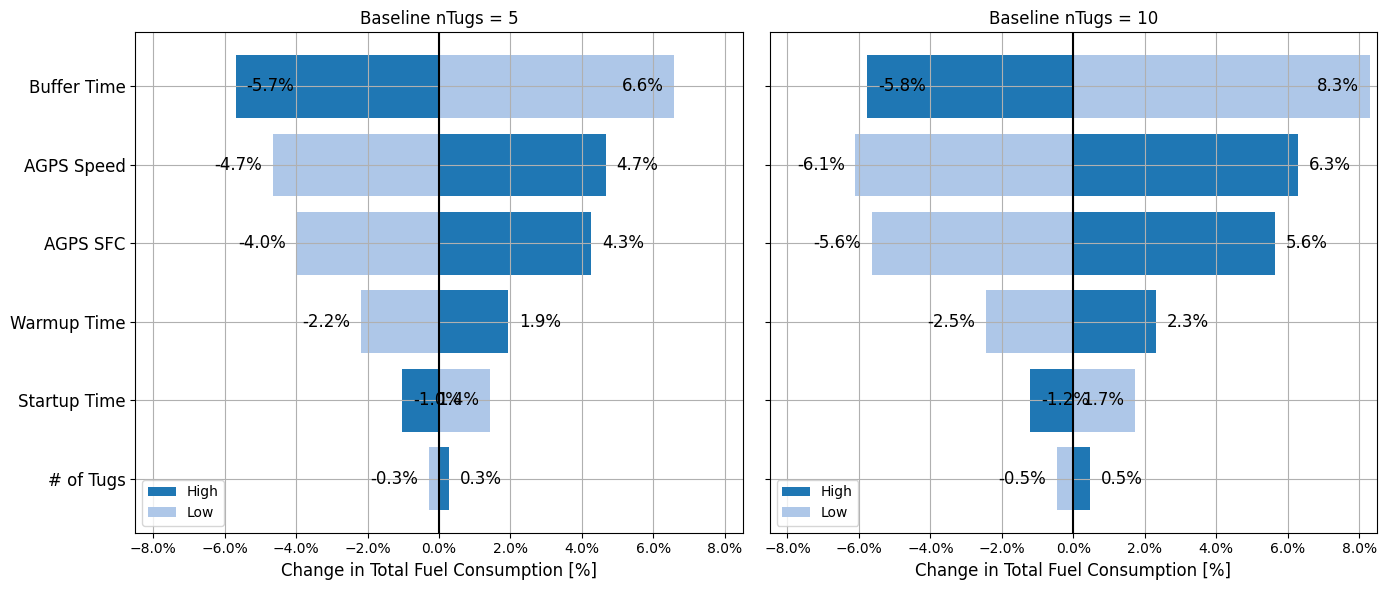

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fontsize_xylabels = 12
fontsize_ticks = 10
custom_labels = ['# of Tugs', 'Startup Time', 'Warmup Time', 'AGPS SFC', 'AGPS Speed', 'Buffer Time']
cmap = plt.colormaps['tab20']

# Helper to get config row
def get_config(df, config_name, nTugs=None):
    if nTugs is not None:
        return df[(df['config_name'] == config_name) & (df['nTugs'] == nTugs)].iloc[0]
    return df[df['config_name'] == config_name].iloc[0]

# Helper to compute deltas
def compute_deltas(df, tugs_base, tugs_low, tugs_high):
    deltas = []

    base = get_config(df, 'startupTime_baseline', nTugs=tugs_base)
    low = get_config(df, 'startupTime_baseline', nTugs=tugs_low)
    high = get_config(df, 'startupTime_baseline', nTugs=tugs_high)
    deltas.append(('nTugs', (low['AGPS_optim_fuel'] - base['AGPS_optim_fuel'])/base['AGPS_optim_fuel']*100,
                              (high['AGPS_optim_fuel'] - base['AGPS_optim_fuel'])/base['AGPS_optim_fuel']*100))

    for param in ['startupTime', 'warmupTime', 'agps_sfc', 'agps_speed', 'buffer_time']:
        low = get_config(df, f'{param}_low', nTugs=tugs_base)
        high = get_config(df, f'{param}_high', nTugs=tugs_base)
        deltas.append((param, (low['AGPS_optim_fuel'] - base['AGPS_optim_fuel'])/base['AGPS_optim_fuel']*100,
                                (high['AGPS_optim_fuel'] - base['AGPS_optim_fuel'])/base['AGPS_optim_fuel']*100))
    df_deltas = pd.DataFrame(deltas, columns=['Variable', 'Low', 'High'])
    df_deltas['Range'] = abs(df_deltas['Low']) + abs(df_deltas['High'])
    return df_deltas.sort_values('Range', ascending=True)

# Prepare both delta DataFrames
df_deltas_5 = compute_deltas(df_results, tugs_base=5, tugs_low=4, tugs_high=6)
df_deltas_10 = compute_deltas(df_results, tugs_base=10, tugs_low=8, tugs_high=12)

# # Plotting
# fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# for ax, df_deltas, title in zip(
#     axes,
#     [df_deltas_5, df_deltas_10],
#     ['Baseline nTugs = 5', 'Baseline nTugs = 10']
# ):
#     y_pos = range(len(df_deltas))
#     ax.barh(y_pos, df_deltas['High'], color=cmap(0), label='High')
#     ax.barh(y_pos, df_deltas['Low'], color=cmap(1), label='Low')

#     ax.set_yticks(y_pos)
#     ax.set_yticklabels(custom_labels, fontsize=fontsize_xylabels)
#     ax.set_xlabel('Change in Total Fuel Consumption [%]', fontsize=fontsize_xylabels)
#     ax.xaxis.set_major_formatter(mtick.PercentFormatter())
#     ax.set_title(title)
#     ax.axvline(x=0, color='black')
#     ax.grid(True)
#     ax.legend(loc='lower left',fontsize=fontsize_ticks)
#     ax.set_xlim(-8.5, +8.5)

# plt.tight_layout()
# plt.savefig('figures/sensitivity_tornado.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, df_deltas, title in zip(
    axes,
    [df_deltas_5, df_deltas_10],
    ['Baseline nTugs = 5', 'Baseline nTugs = 10']
):
    y_pos = range(len(df_deltas))
    bars_high = ax.barh(y_pos, df_deltas['High'], color=cmap(0), label='High')
    bars_low = ax.barh(y_pos, df_deltas['Low'], color=cmap(1), label='Low')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(custom_labels, fontsize=fontsize_xylabels)
    ax.set_xlabel('Change in Total Fuel Consumption [%]', fontsize=fontsize_xylabels)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_title(title)
    ax.axvline(x=0, color='black')
    ax.grid(True)
    ax.legend(loc='lower left', fontsize=fontsize_ticks)
    ax.set_xlim(-8.5, +8.5)

    # Annotate each bar
    for bar in bars_high:
        width = bar.get_width()
        y = bar.get_y() + bar.get_height() / 2
        ax.text(width + 0.3, y, f'{width:.1f}%', va='center', ha='left', fontsize=fontsize_xylabels)

    for bar in bars_low:
        width = bar.get_width()
        y = bar.get_y() + bar.get_height() / 2
        ax.text(width - 0.3, y, f'{width:.1f}%', va='center', ha='right', fontsize=fontsize_xylabels)

plt.tight_layout()
plt.savefig('figures/sensitivity_tornado.pdf', format='pdf', dpi=300, bbox_inches='tight')
